In [1]:
using Distributed, Plotly, DataFrames, Plots, PyPlot
plotly()
addprocs(7)

@everywhere using StatsBase, Distributions, SharedArrays, CSV
@everywhere include("episiming.jl");

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-17821923478934553500\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-15090728444630674002\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-17821923478934553500\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

┌ Info: For saving to png with the Plotly backend ORCA has to be installed.
└ @ Plots /home/rodrigo/.julia/packages/Plots/ninUP/src/backends.jl:375


In [2]:
@everywhere function powerDecay(a::Number, b::Number, x)
    y = rowWiseNorm(x)
    return 1.0 ./ (1.0 .+ (y ./ a) .^ b)
end

@everywhere  fKernel(x) = powerDecay(1., 1.5, x)

In [3]:
@everywhere censoResidencial = [.21, .26, .20, .17, .08, .04, .02, 0.02];

In [4]:
@everywhere geradorCenso(x) = geraResidencias(x, censoResidencial)
@everywhere geradorDensidade(k) = (x) -> geraResidencias(x, k)

# Rio de Janeiro

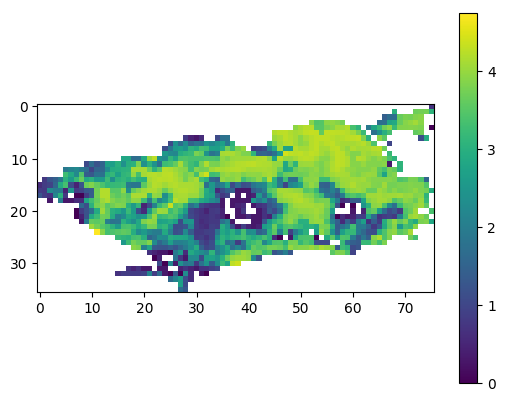

In [5]:
file = open("landScan.bin", "r")
data = reinterpret(Int64, read(file))
close(file)

dadosRJ = reshape(data, (36, 76));
dadosRJ[dadosRJ .< 0] .= 0;

PyPlot.imshow(log10.(dadosRJ))
PyPlot.colorbar();

In [6]:
dadosAjustados = floor.(Int, dadosRJ ./ 10);

In [7]:
αᵣ = 0.8
βᵢ = 0.30
βₐ = 0.05

@everywhere geradorθᵢ() = (self::Particula, x) -> βᵢ / self.n ^ αᵣ
@everywhere geradorθₐ() = (self::Particula, x) -> βₐ / self.n ^ αᵣ

In [8]:
@time populacao = geraRedeResidencial(dadosAjustados, geradorCenso, geradorθᵢ, geradorθₐ, 1000, fKernel);

 17.446946 seconds (19.91 M allocations: 7.873 GiB, 14.07% gc time)


In [9]:
piramide = CSV.read("piramide_etaria_MRJ.csv")
piramide = vec(convert(Array, piramide[:, 2:end]));

In [10]:
idades = Array(0:24)
append!(idades, 25:5:100);

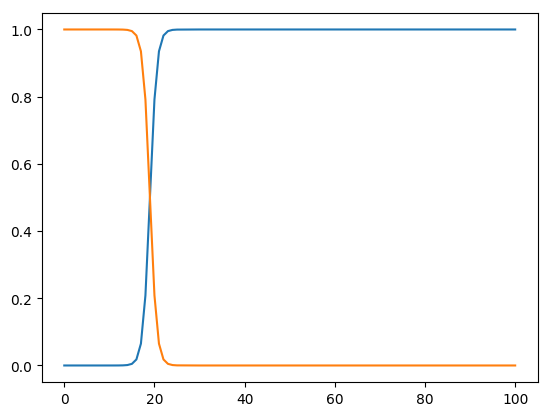

In [11]:
faixas = [(tanh.(i .* (idades .- 19)) .+ 1) / 2 for i in [2/3, -2/3]]

for i in faixas
    PyPlot.plot(idades, i)
end

In [12]:
geraIdade!(populacao, piramide, faixas);

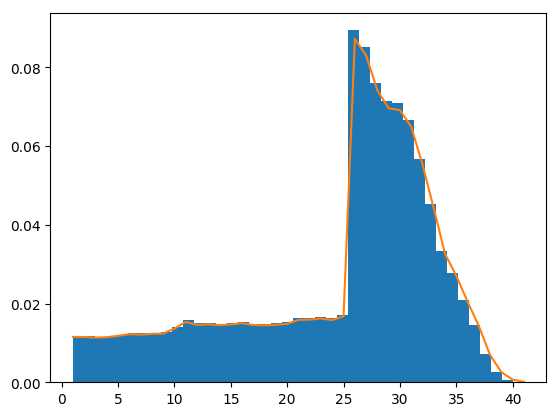

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe7efd2bda0>

In [13]:
PyPlot.hist(populacao.idades, density=true, bins=41)
PyPlot.plot(1:41, piramide / sum(piramide))

In [ ]:
# ρForma = 0.2 # shape factor of gamma distribution
# ρEscala = 5 # scale (mean value = scale * shape)
# ρPop = rand(Gamma(ρForma, ρEscala), nPessoas)
@time dist = calculaDistancia(populacao, fKernel);
@eval @everywhere dist=$dist

In [46]:
βᵤᵢ = 0.1
βᵤₐ = 0.02
γ = 0.1;

parametros = SEIR(fKernel, γ, 1/3, 4/6, (t) -> βᵤᵢ ./ dist, (t) -> βᵤₐ ./ dist, (a, t) -> ones(length(a)));

In [ ]:
# ρForma = 0.2 # shape factor of gamma distribution
# ρEscala = 5 # scale (mean value = scale * shape)
# ρPop = rand(Gamma(ρForma, ρEscala), nPessoas)
@time dist2 = calculaDistancia(populacao, fKernel, false);
@eval @everywhere dist2=$dist2

In [47]:
parametros2 = SEIR(fKernel, γ, 1/3, 4/6, (t) -> βᵤᵢ ./ dist2, (t) -> βᵤₐ ./ dist2, (a, t) -> ones(length(a)));

# Paralelismo simples das simulações

In [16]:
nSim = nworkers() * 3
tempos =  Array(1:180);

In [88]:
function calculaDistancia(populacao::Populacao, diaContagio, cargaViral, t, suscetiveis, infectados, fKernel)
    """
        Calculo da distância entre todas as pessoas, tomando a distnacia media entre pessoas de bairros diferentes
    """
    aux = zeros(populacao.n)
    infectadosBairros = [sum(populacao.ρ[i.pessoas[infectados[i.pessoas]]] .* cargaViral(diaContagio[i.pessoas[infectados[i.pessoas]]], t)) for i in populacao.bairros]
    indices = 1:length(populacao.bairros)
    for (i, bairro) in enumerate(populacao.bairros)
        suscetiveisBairro = bairro.pessoas[suscetiveis[bairro.pessoas]]
        infectadosBairro = bairro.pessoas[infectados[bairro.pessoas]]

        aux[suscetiveisBairro] .+= sum(infectadosBairros .* bairro.distancias .* (indices .!= i))

        taxas = (populacao.ρ[infectadosBairro] .* cargaViral(diaContagio[infectadosBairro], t))'
        for j in suscetiveisBairro
            aux[j] += sum(fKernel(populacao.posicoes[infectadosBairro, :] .- populacao.posicoes[j, :]') .* taxas)
        end        
    end
    return aux[suscetiveis]
end

calculaDistancia (generic function with 5 methods)

In [92]:
@time a = @evolucaoParalela(populacao, Array(1:60), parametros, nworkers());

262.595105 seconds (330.36 k allocations: 111.010 MiB)


In [93]:
@time b = @evolucaoParalela(populacao, Array(1:60), parametros2, nworkers(), false);

 64.861560 seconds (326.20 k allocations: 110.874 MiB)


In [31]:
function map2matriz(a)
    (nSim, nT) = (length(a), length(a[1][1]))
    S = zeros(nSim, nT)
    E = zeros(nSim, nT)
    A = zeros(nSim, nT)
    I = zeros(nSim, nT)
    R = zeros(nSim, nT)
    transicoes = zeros(nSim, size(a[1][6])[1], 3)
    
    for (i, j) in enumerate(a)
        S[i, :] = j[1]
        E[i, :] = j[2]
        A[i, :] = j[3]
        I[i, :] = j[4]
        R[i, :] = j[5]
        transicoes[i, :, :] = j[6]
    end
    return S, E, A, I, R, transicoes
end

map2matriz (generic function with 1 method)

In [94]:
S1,E1,A1,I1,R1,transicoes1 = map2matriz(a);

In [95]:
Plots.plot((mean(S1, dims=1)[1, :]), label = "Suscetíveis")
Plots.plot!((mean(I1+A1, dims=1)[1, :]), label = "Infectados")
Plots.plot!((mean(R1, dims=1)[1, :]), label = "Recuperados")

<!DOCTYPE html>
 
 
 Plots.jl

In [96]:
S2,E2,A2,I2,R2,transicoes2 = map2matriz(b);

In [97]:
Plots.plot((mean(S2, dims=1)[1, :]), label = "Suscetíveis")
Plots.plot!((mean(I2+A2, dims=1)[1, :]), label = "Infectados")
Plots.plot!((mean(R2, dims=1)[1, :]), label = "Recuperados")

<!DOCTYPE html>
 
 
 Plots.jl

In [107]:
maximum(abs.((mean(R1 + I1 + A1, dims=1)[1, :] - mean(R2 + I2 + A2, dims=1)[1, :]) ./ mean(R1 + I1 + A1, dims=1)[1, :]))

0.016478397577733783